# EXPLORE Data Science Academy Classification Hackathon

## 1. Introduction

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society. With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.
In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in.


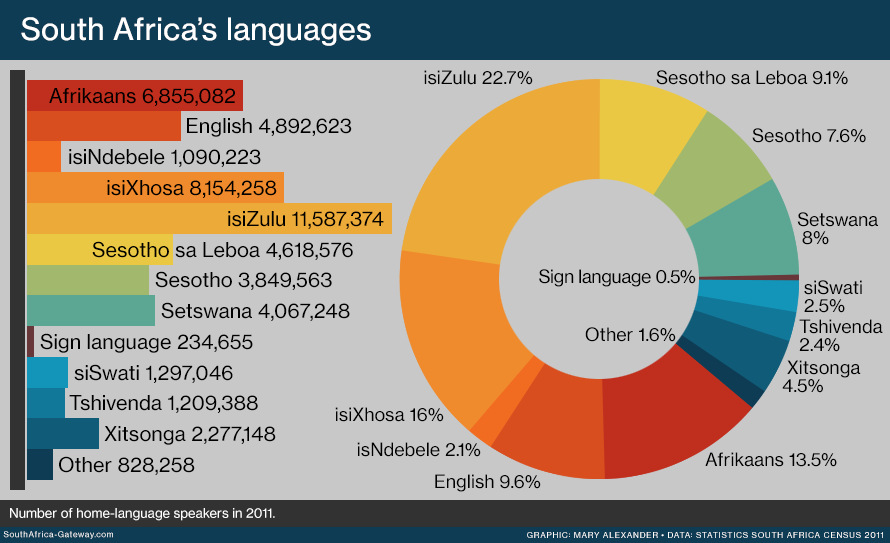

## 1.1 Problem Statement

The task is to develop a machine learning model to identify language within a text, among the South Africa's 11 official languages.

## 2. Import Python Libraries


Let's import everything we need to begin. This will include techniques for text feature extraction and ways to divide our data. The models we want to train will be included in the subsequent sections.

In [1]:
# Loading Data
import pandas as pd
import numpy as np
import nltk
import string
import re
import time

# Explore Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pyplot import rcParams
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import CountVectorizer


# Data Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
ps = PorterStemmer()
wn = nltk.WordNetLemmatizer()


#NLTK (Natural Language Tool Kit) 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import nltk



## 2.1 Load Datasets

In [2]:
# Load the train & test data sets
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

## 3. Exploratory Data Analysis

This section aims to conduct initial investigation on the dataset, to identify patterns, anomalies, and suggestive hypotheses of the dataset. Among other features explored are infomation and shape on both train and test sets

In [3]:
# Viewing the first 5 rows of train_df
train_df.head()


,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
#viewing the first 5 rows of test_df
test_df.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [5]:
print(train_df.info()) #checking the data type of each column in the train data
print('\n')
print(test_df.info()) #checking the data type of each column in the test data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB
None


In [6]:
# Display of the data statistics using the transpose method
train_df.describe().T


,count,unique,top,freq
lang_id,33000,11,xho,3000
text,33000,29948,ngokwesekhtjheni yomthetho ophathelene nalokhu...,17


In [7]:
test_df.describe().T


,count,mean,std,min,25%,50%,75%,max
index,5682.0,2841.5,1640.396446,1.0,1421.25,2841.5,4261.75,5682.0


In [8]:
# Check for test data missing values 
test_df.isnull().sum()

index    0
text     0
dtype: int64

In [9]:
# Check for train data missing values 
train_df.isnull().sum()

lang_id    0
text       0
dtype: int64

In [10]:
lang = train_df['text']

# Creating a dataframe from the text column
lang_df = pd.DataFrame(lang)

# Add sentiment column to the language dataframe
lang_df['lang_id'] = train_df['lang_id']

# View the top 3 rows of languages
lang_df.head(3)

,text,lang_id
0,umgaqo-siseko wenza amalungiselelo kumaziko ax...,xho
1,i-dha iya kuba nobulumko bokubeka umsebenzi na...,xho
2,the province of kwazulu-natal department of tr...,eng


## 4. Data Processing

To process the data, a function cleaner is initialized, whose main purpose is (-)
        1. Convet the text into lower case
        2. Remove URLS,Hashtags(if any),Numeric Values, and Character Notes 
        3. Strip pucntuations and special characters
        4. Remove white spaces and RTs (if any).
        

In [11]:
def cleaner(texter):
    """
    this function takes in a dataframe and perform the following:
    -Convert letters to lowercases
    -remove URL links
    -remove # from hashtags
    -remove numbers
    -remove punctuation
    from the text field then return a clean dataframe 
    """
    texter = texter.lower() #convert to text to lowercase
    to_remove = [
        r"@[\w]*",  # strip account mentions
        r"http(s?):\/\/.*\/\w*",  # strip URLs
        r"#\w*",  # strip hashtags
        r"\d+",  # delete numeric values
        r"U+FFFD",  # remove the "character note present" diamond
    ]
    for key in to_remove:
        texter = re.sub(key, "", texter)
    
    # strip punctuation and special characters
    texter = re.sub(r"[,.;':@#?!\&/$]+\ *", " ", texter)
    
    # strip excess white-space
    texter = re.sub(r"\s\s+", " ", texter)
    texter = re.sub(r'rt[\s]+', '', texter) #Remove RT
    
    return texter.lstrip(" ")

Now let us apply the cleaner fuction to both train and test datasets.

In [12]:
#apply function to remove noise in the data
train_df['text'] = train_df['text'].apply(cleaner)  
test_df['text'] = test_df['text'].apply(cleaner)  


The next point to take into account is that a word is likely to have no impact on detecting the tone of the text if it appears just once in the entire sample of data. As a result, we may exclude all of the dataset's infrequent words, which are typically proper nouns and other words that are irrelevant to the situation at hand.

In [13]:
train_df.tail()

,lang_id,text
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999,sot,mafapha a mang le ona a lokela ho etsa ditlale...


Assigning X and y variables

In [14]:
y=train_df['lang_id']
X=train_df['text']

## 5. Model Building and Evaluation

We will specify the model names and invoke the classes that implement the model. Keep in mind that some of the classifiers require input variables. These are some instances of hyperparameters.

In [15]:
#Feature Engineering and Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [16]:
#Split the train data set using the train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33, random_state = 42)

Before training the models, I considered TF-IDF & Count Vectors for feature extration to express the data numerically. 

In [17]:
#build a pipeline
pipeline1 = Pipeline([
    ('bow',CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.5, 
                             ngram_range=(1, 1))),  # strings to token integer counts
    
    ('classifier', MultinomialNB(alpha=0.006)),  # train on Naive Bayes classifier
])

In [18]:
#execute the pipeline
pipeline1.fit(X_train,y_train)
predictions = pipeline1.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       986
         eng       1.00      1.00      1.00       991
         nbl       1.00      1.00      1.00       952
         nso       1.00      1.00      1.00      1025
         sot       1.00      1.00      1.00      1024
         ssw       1.00      1.00      1.00       999
         tsn       1.00      1.00      1.00       982
         tso       1.00      1.00      1.00       952
         ven       1.00      1.00      1.00      1034
         xho       1.00      1.00      1.00      1005
         zul       1.00      1.00      1.00       940

    accuracy                           1.00     10890
   macro avg       1.00      1.00      1.00     10890
weighted avg       1.00      1.00      1.00     10890

[[ 984    0    0    0    0    0    1    0    0    1    0]
 [   0  991    0    0    0    0    0    0    0    0    0]
 [   0    0  950    0    0    0    0    0    0    1    1]
 [   0    0  

In [19]:
from sklearn. model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

#fitting a MultinomialNB with parameter
pipe_nb = make_pipeline(
    CountVectorizer(),
    MultinomialNB(alpha=0.06)
)
scores = cross_validate(pipe_nb, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,1.047533,0.226145,0.998869,1.0
1,1.077443,0.184285,0.999548,1.0
2,1.040179,0.196374,0.999322,1.0
3,1.187661,0.178940,0.999095,1.0
4,1.039763,0.185851,0.999095,1.0


In [23]:
#fitting a MultinomialNB with parameter
pipe_nb6 = make_pipeline(
    CountVectorizer(),
    MultinomialNB(alpha=0.006)
)
scores = cross_validate(pipe_nb6, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,1.692039,0.249360,0.998869,1.0
1,1.341546,0.271603,0.998869,1.0
2,1.245893,0.170948,0.999548,1.0
3,0.971355,0.173786,0.999095,1.0
4,1.049208,0.169596,0.998643,1.0


In [21]:
pipe_nb2 = make_pipeline(
    CountVectorizer(),
    LogisticRegression(max_iter=15)
)
scores = cross_validate(pipe_nb2, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,7.429573,0.190768,0.991859,0.999943
1,6.616190,0.189025,0.995703,0.999943
2,6.516070,0.196813,0.990954,0.999943
3,6.882171,0.271842,0.992085,1.000000
4,6.767561,0.224532,0.992311,0.999322


In [22]:
pipe_nb3 = make_pipeline(
    CountVectorizer(),
    SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True,max_iter=15)
)
scores = cross_validate(pipe_nb3, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,9.463646,0.921789,0.866350,0.860188
1,10.282193,0.902547,0.875848,0.876696
2,9.457245,1.034772,0.850068,0.856569
3,10.874694,0.914789,0.831976,0.837800
4,9.539871,0.941881,0.847580,0.851029


In [24]:
pipe_nb4 = make_pipeline(
    CountVectorizer(),
    RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)
)
scores = cross_validate(pipe_nb4, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,6.297635,0.656847,0.876979,0.882689
1,2.501081,0.670274,0.895296,0.884724
2,2.570693,0.665946,0.874491,0.878788
3,2.469936,0.681747,0.860470,0.870647
4,2.488734,0.657898,0.876074,0.874152


In [25]:
pipe_nb5 = make_pipeline(
    CountVectorizer(),
    SGDClassifier(alpha=0.001, random_state=5, max_iter=50, tol=None)
)
scores = cross_validate(pipe_nb5, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,3.228649,0.210843,0.995929,1.0
1,2.972692,0.202809,0.997286,1.0
2,2.924706,0.213836,0.995251,1.0
3,3.024064,0.223614,0.993668,1.0
4,2.982608,0.200822,0.995477,1.0


My best perfoming model was MultinomialNB(alpha=0.06) with CountVectorizer feature selection, even after hyperparameter tuning to improve model perfomance.

## 6. Exporting Model and Kaggle Submission

In [26]:
test = test_df['text']
pipe_nb.fit(X,y)
y_pred = pipe_nb.predict(test)

submission = pd.DataFrame(y_pred, columns = ['lang_id'])
submission['index'] = test_df ['index']
submission = submission[['index','lang_id']]
submission.to_csv('submission_pipeline21.csv', index=False)

In [27]:
test = test_df['text']
pipe_nb3.fit(X,y)
y_pred = pipe_nb3.predict(test)

submission = pd.DataFrame(y_pred, columns = ['lang_id'])
submission['index'] = test_df ['index']
submission = submission[['index','lang_id']]
submission.to_csv('submission_pipeline12.csv', index=False)

In [28]:
test = test_df['text']
pipe_nb6.fit(X,y)
y_pred = pipe_nb6.predict(test)

submission = pd.DataFrame(y_pred, columns = ['lang_id'])
submission['index'] = test_df ['index']
submission = submission[['index','lang_id']]
submission.to_csv('submission_pipeline22.csv', index=False)

## 7.Conclusion


##### The most accurate model, MultinomialNB, had an accuracy of up to 96.444%.
This could be as a result of the uniqueness of this particular dataset, where the presence of cultural worldings has distinct impact on the predictions.

## 8. Reference

Nazrul, S. (2018). Multinomial Naive Bayes Classifier for Text Analysis (Python). Medium. Retrieved 25 June 2022, from https://towardsdatascience.com/multinomial-naive-bayes-classifier-for-text-analysis-python-8dd6825ece67.